# Интеграция оценок новостей в временные ряды с аномалиями

Этот ноутбук предназначен для интеграции оценок новостей из различных моделей в временные ряды с обнаруженными аномалиями.

## Задачи:
1. Загрузить данные из series_with_anomaly и news
2. Добавить 5 новых колонок:
   - Средняя оценка за день от KerAI
   - Средняя оценка за день от Гигачат
   - Средняя оценка за день от DeepSeek
   - Текст заголовков за день
   - Взвешенная оценка с затухающим сигналом
3. Сохранить результаты в папку series_with_news
4. Визуализировать цену и новостной фон
5. Посчитать корреляцию между оценками и доходностями


In [ ]:
!pip install virtualenv

In [ ]:
import virtualenv
import subprocess
import os
import sys

notebook_name = "news"
virtualenv.cli_run(["venvs/" + notebook_name, "--no-download"])

venv_dir = "venvs/" + notebook_name
python_path = os.path.join(venv_dir, "bin", "python")
display_name = "Python (" + notebook_name + ")"
kernel_name = notebook_name

# Установка ipykernel в venv
subprocess.check_call([os.path.join(venv_dir, "bin", "pip"), "install", "ipykernel"])

# Регистрация ядра
subprocess.check_call([
    python_path, "-m", "ipykernel", "install",
    "--user",
    "--name", kernel_name,
    "--display-name", display_name
])

In [1]:
import sys
print(sys.executable)

/workspace/news_processors/venvs/news/bin/python


In [ ]:
import subprocess
import os
import sys

# Путь к pip в активном ядре
pip_path = os.path.join(sys.prefix, "bin", "pip")

subprocess.check_call([pip_path, "install", "matplotlib", "pandas", "numpy", "seaborn"])

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Установка русского языка для графиков
plt.rcParams['font.family'] = ['DejaVu Sans', 'sans-serif']

print("Библиотеки загружены успешно")

Библиотеки загружены успешно


In [4]:
# Пути к данным
SERIES_PATH = '../data/series_with_anomaly/'
NEWS_PATH = '../data/news/'
OUTPUT_PATH = '../data/series_with_news/'

# Создаем выходную папку если её нет
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Список тикеров
tickers = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']

print(f"Рабочие директории:")
print(f"- Временные ряды с аномалиями: {SERIES_PATH}")
print(f"- Новости: {NEWS_PATH}")
print(f"- Выходные данные: {OUTPUT_PATH}")
print(f"\nТикеры для обработки: {tickers}")

Рабочие директории:
- Временные ряды с аномалиями: ../data/series_with_anomaly/
- Новости: ../data/news/
- Выходные данные: ../data/series_with_news/

Тикеры для обработки: ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']


## Функции для обработки данных


In [5]:
def load_series_data(ticker):
    """Загружает данные временного ряда для тикера"""
    file_path = f"{SERIES_PATH}{ticker}_with_anomalies.csv"
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    return df

def load_news_data(ticker):
    """Загружает новостные данные для тикера"""
    file_path = f"{NEWS_PATH}{ticker}_evaluated_news.csv"
    df = pd.read_csv(file_path)
    df['published'] = pd.to_datetime(df['published'])
    df['date'] = df['published'].dt.date
    return df

def safe_convert_to_numeric(value, default=0):
    """Безопасно конвертирует значение в число"""
    if pd.isna(value) or value == 'Error_Evaluation_Gigachat':
        return default
    try:
        return float(value)
    except:
        return default

def process_daily_news_scores(news_df: pd.DataFrame) -> pd.DataFrame:
    """Обрабатывает новостные данные и вычисляет дневные оценки."""
    df = news_df.copy()
    
    # 1) Конвертируем и нормируем
    df['kernai_score']   = df['KernAI_stock_news_distilbert'].apply(lambda x: safe_convert_to_numeric(x, 0))
    df['gigachat_score'] = df['gigachat_score_only'].apply(lambda x: safe_convert_to_numeric(x, 0))
    df['deepseek_score'] = df['deepseek_score'].apply(lambda x: safe_convert_to_numeric(x, 0))
    
    df['kernai_norm']   = df['kernai_score']   / 100.0
    df['gigachat_norm'] = df['gigachat_score'] / 100.0
    df['deepseek_norm'] = df['deepseek_score'] / 100.0
    
    # 2) Агрегируем численные метрики
    daily_nums = (
        df
        .groupby('date')
        .agg(
            kernai_daily_avg   = ('kernai_norm',   'mean'),
            gigachat_daily_avg = ('gigachat_norm', 'mean'),
            deepseek_daily_avg = ('deepseek_norm', 'mean')
        )
    )
    
    # 3) Собираем заголовки для каждого дня
    daily_heads = (
        df
        .sort_values('published')
        .groupby('date')
        .apply(lambda g: " | ".join(
            f"{ts.strftime('%H:%M')}: {title}"
            for ts, title in zip(g['published'], g['title'])
        ))
        .rename('daily_headlines')
    )
    
    # 4) Объединяем в один DataFrame
    daily_scores = (
        daily_nums
        .join(daily_heads)
        .reset_index()
    )
    
    return daily_scores

print("Функции загрузки и обработки данных определены")

Функции загрузки и обработки данных определены


In [6]:
def calculate_weighted_score_with_decay(daily_scores):
    """Вычисляет взвешенную оценку с затухающим сигналом"""
    df = daily_scores.copy()
    
    # Веса для моделей
    weights = {
        'kernai': 0.2,
        'gigachat': 0.3,
        'deepseek': 0.5
    }
    
    # Вычисляем базовую взвешенную оценку
    df['weighted_score_base'] = (
        weights['kernai'] * df['kernai_daily_avg'] +
        weights['gigachat'] * df['gigachat_daily_avg'] +
        weights['deepseek'] * df['deepseek_daily_avg']
    )
    
    # Инициализируем итоговую взвешенную оценку
    df['weighted_score_with_decay'] = df['weighted_score_base'].copy()
    
    # Применяем затухающий сигнал
    for i in range(1, len(df)):
        # Затухание предыдущего дня (деление на 2)
        decay_from_prev = df.iloc[i-1]['weighted_score_with_decay'] / 2
        
        # Если есть данные за 2 дня назад, добавляем затухание (деление на 4)
        if i >= 2:
            decay_from_prev2 = df.iloc[i-2]['weighted_score_with_decay'] / 4
        else:
            decay_from_prev2 = 0
            
        # Если есть данные за 3 дня назад, влияние практически исчезает (деление на 8)
        if i >= 3:
            decay_from_prev3 = df.iloc[i-3]['weighted_score_with_decay'] / 8
        else:
            decay_from_prev3 = 0
        
        # Итоговый сигнал = текущий день + затухающие сигналы прошлых дней
        # Ограничиваем влияние прошлых дней, чтобы не было слишком сильного накопления
        total_decay = decay_from_prev + decay_from_prev2 * 0.5 + decay_from_prev3 * 0.25
        
        df.iloc[i, df.columns.get_loc('weighted_score_with_decay')] = (
            df.iloc[i]['weighted_score_base'] + total_decay
        )
    
    return df

print("Функция расчета взвешенной оценки с затуханием определена")

Функция расчета взвешенной оценки с затуханием определена


## Обработка данных для всех тикеров

In [7]:
# Словарь для хранения обработанных данных
integrated_data = {}
correlation_results = {}

for ticker in tickers:
    print(f"\nОбработка тикера: {ticker}")
    
    try:
        # Загружаем данные
        series_df = load_series_data(ticker)
        news_df = load_news_data(ticker)
        
        print(f"  - Загружено {len(series_df)} записей временного ряда")
        print(f"  - Загружено {len(news_df)} новостей")
        
        # Обрабатываем новостные оценки
        daily_news = process_daily_news_scores(news_df)
        
        # Вычисляем взвешенную оценку с затуханием
        daily_news_with_decay = calculate_weighted_score_with_decay(daily_news)
        
        print(f"  - Обработано {len(daily_news_with_decay)} дневных новостных оценок")
        
        # Объединяем данные временного ряда с новостными оценками
        integrated_df = series_df.merge(
            daily_news_with_decay, 
            on='date', 
            how='left'
        )
        
        # Заполняем пропуски нулями для новостных данных
        news_columns = ['kernai_daily_avg', 'gigachat_daily_avg', 'deepseek_daily_avg', 
                       'weighted_score_base', 'weighted_score_with_decay']
        for col in news_columns:
            integrated_df[col] = integrated_df[col].fillna(0)
        
        # Заполняем пропуски в заголовках
        integrated_df['daily_headlines'] = integrated_df['daily_headlines'].fillna('Новости отсутствуют')
        
        # Вычисляем доходности
        integrated_df['return'] = integrated_df['close'].pct_change()
        
        # Сохраняем результат
        output_file = f"{OUTPUT_PATH}{ticker}_with_news.csv"
        integrated_df.to_csv(output_file, index=False)
        
        # Сохраняем для дальнейшего анализа
        integrated_data[ticker] = integrated_df
        
        print(f"  - Сохранено в {output_file}")
        print(f"  - Итоговые размеры: {integrated_df.shape}")
        
    except Exception as e:
        print(f"  - Ошибка при обработке {ticker}: {str(e)}")

print(f"\nОбработка завершена. Обработано {len(integrated_data)} тикеров.")


Обработка тикера: AFLT
  - Загружено 2375 записей временного ряда
  - Загружено 734 новостей
  - Обработано 548 дневных новостных оценок
  - Сохранено в ../data/series_with_news/AFLT_with_news.csv
  - Итоговые размеры: (2375, 16)

Обработка тикера: LKOH
  - Загружено 2375 записей временного ряда
  - Загружено 741 новостей
  - Обработано 579 дневных новостных оценок
  - Сохранено в ../data/series_with_news/LKOH_with_news.csv
  - Итоговые размеры: (2375, 16)

Обработка тикера: MOEX
  - Загружено 2375 записей временного ряда
  - Загружено 547 новостей
  - Обработано 421 дневных новостных оценок
  - Сохранено в ../data/series_with_news/MOEX_with_news.csv
  - Итоговые размеры: (2375, 16)

Обработка тикера: NVTK
  - Загружено 2373 записей временного ряда
  - Загружено 537 новостей
  - Обработано 446 дневных новостных оценок
  - Сохранено в ../data/series_with_news/NVTK_with_news.csv
  - Итоговые размеры: (2373, 16)

Обработка тикера: PIKK
  - Загружено 2375 записей временного ряда
  - Загру

## Визуализация результатов



График для AFLT:


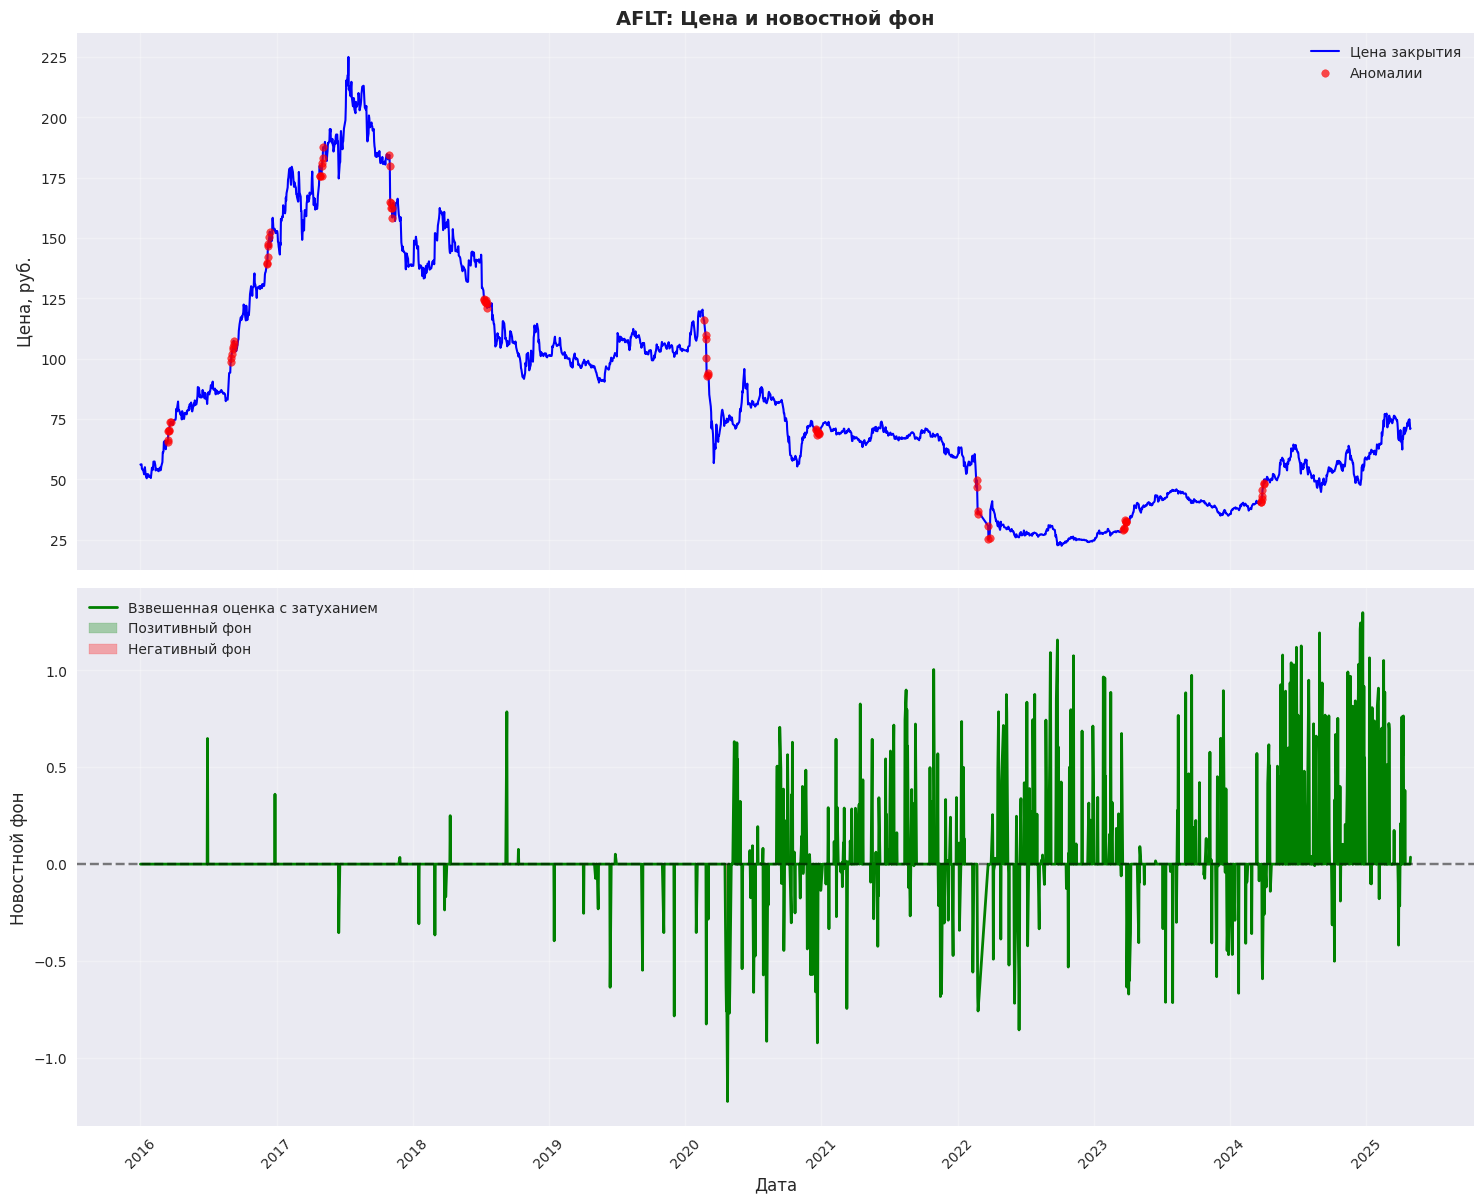


График для LKOH:


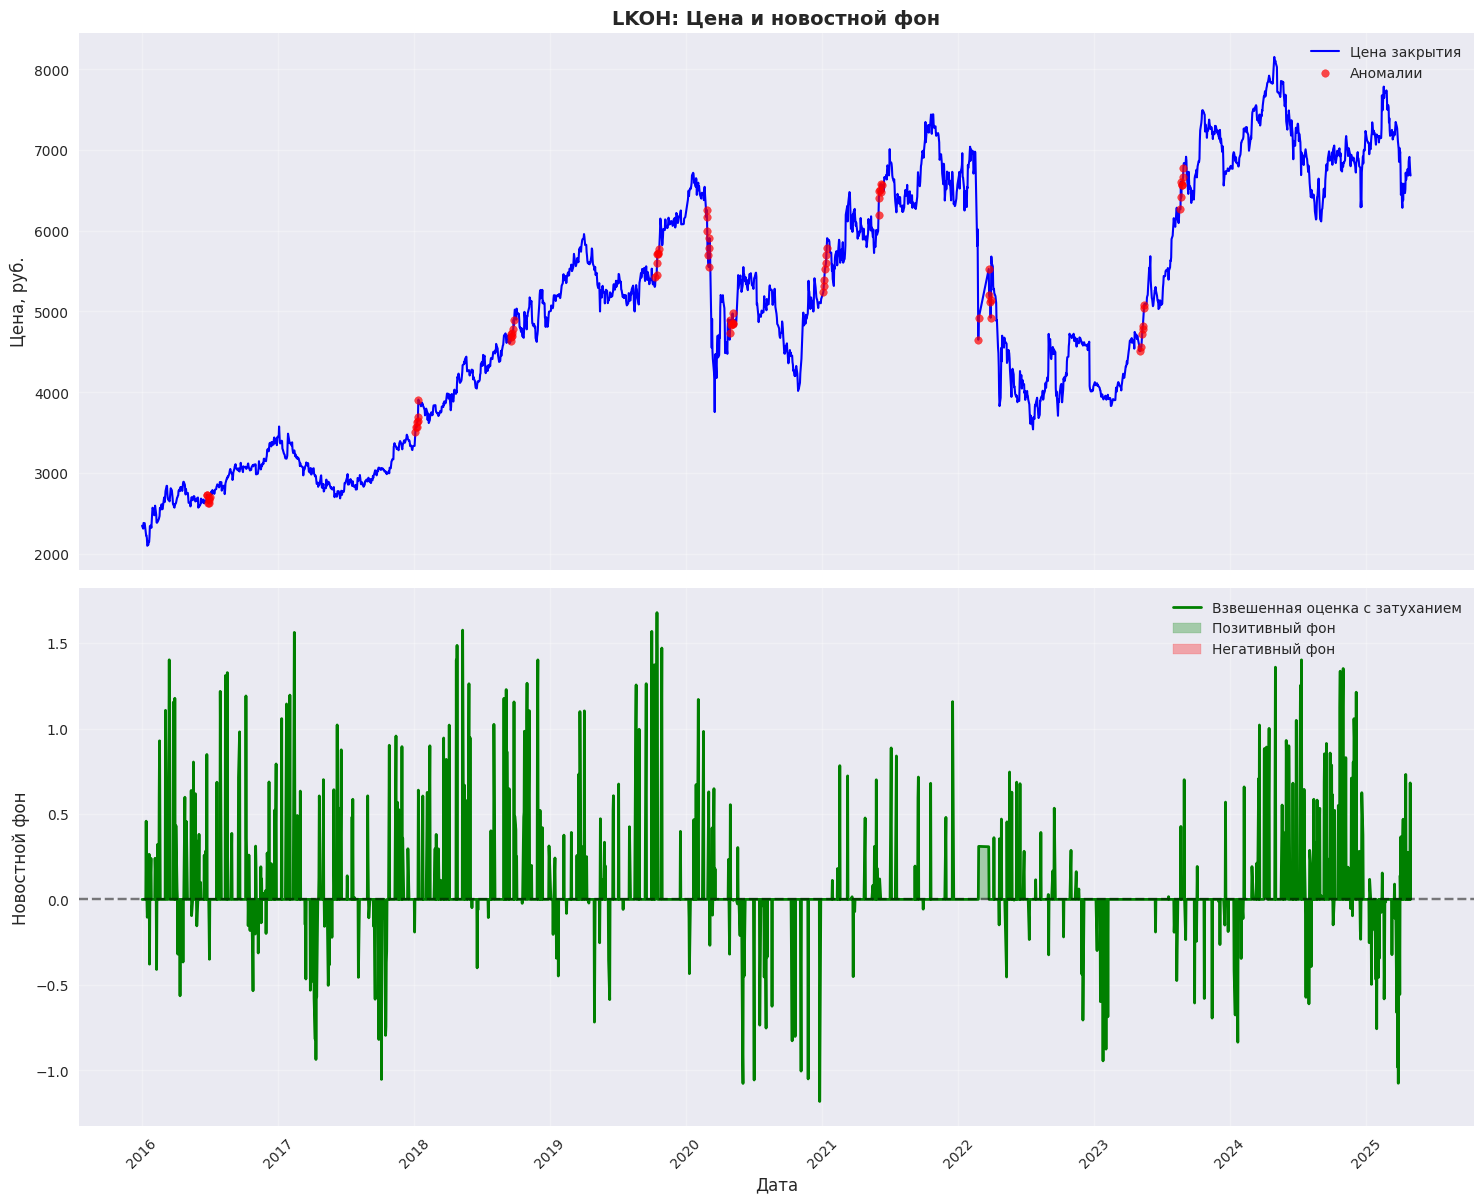


График для MOEX:


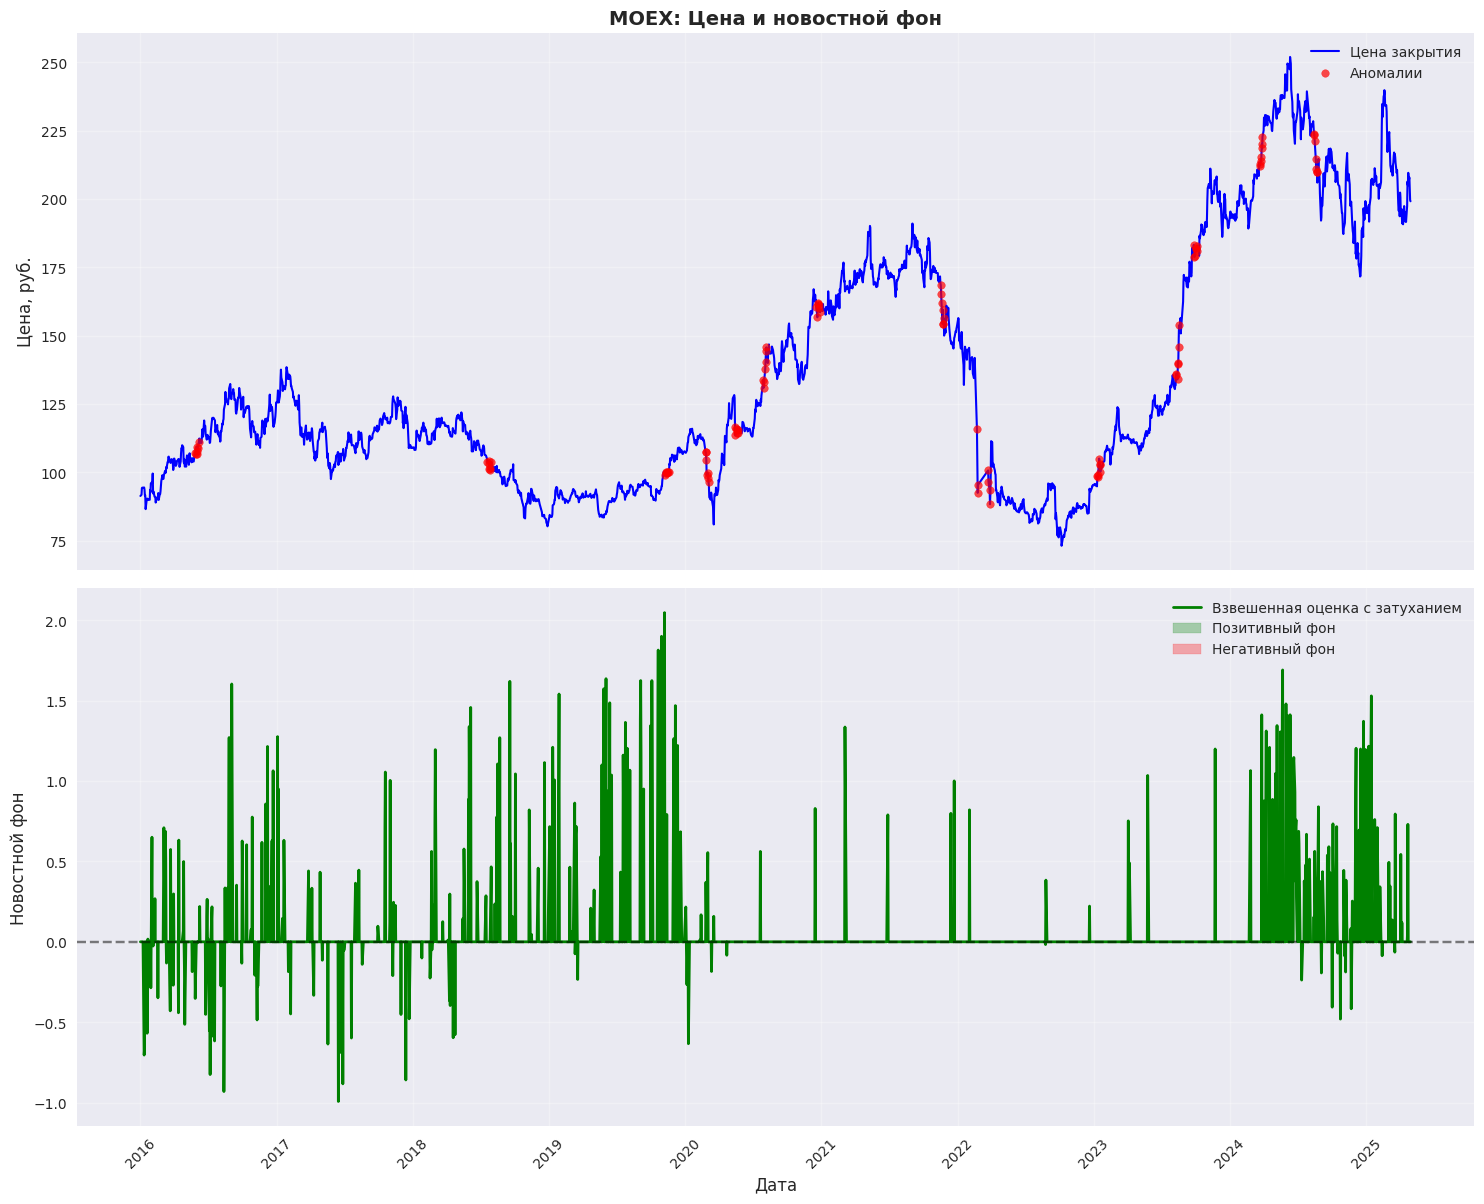


График для NVTK:


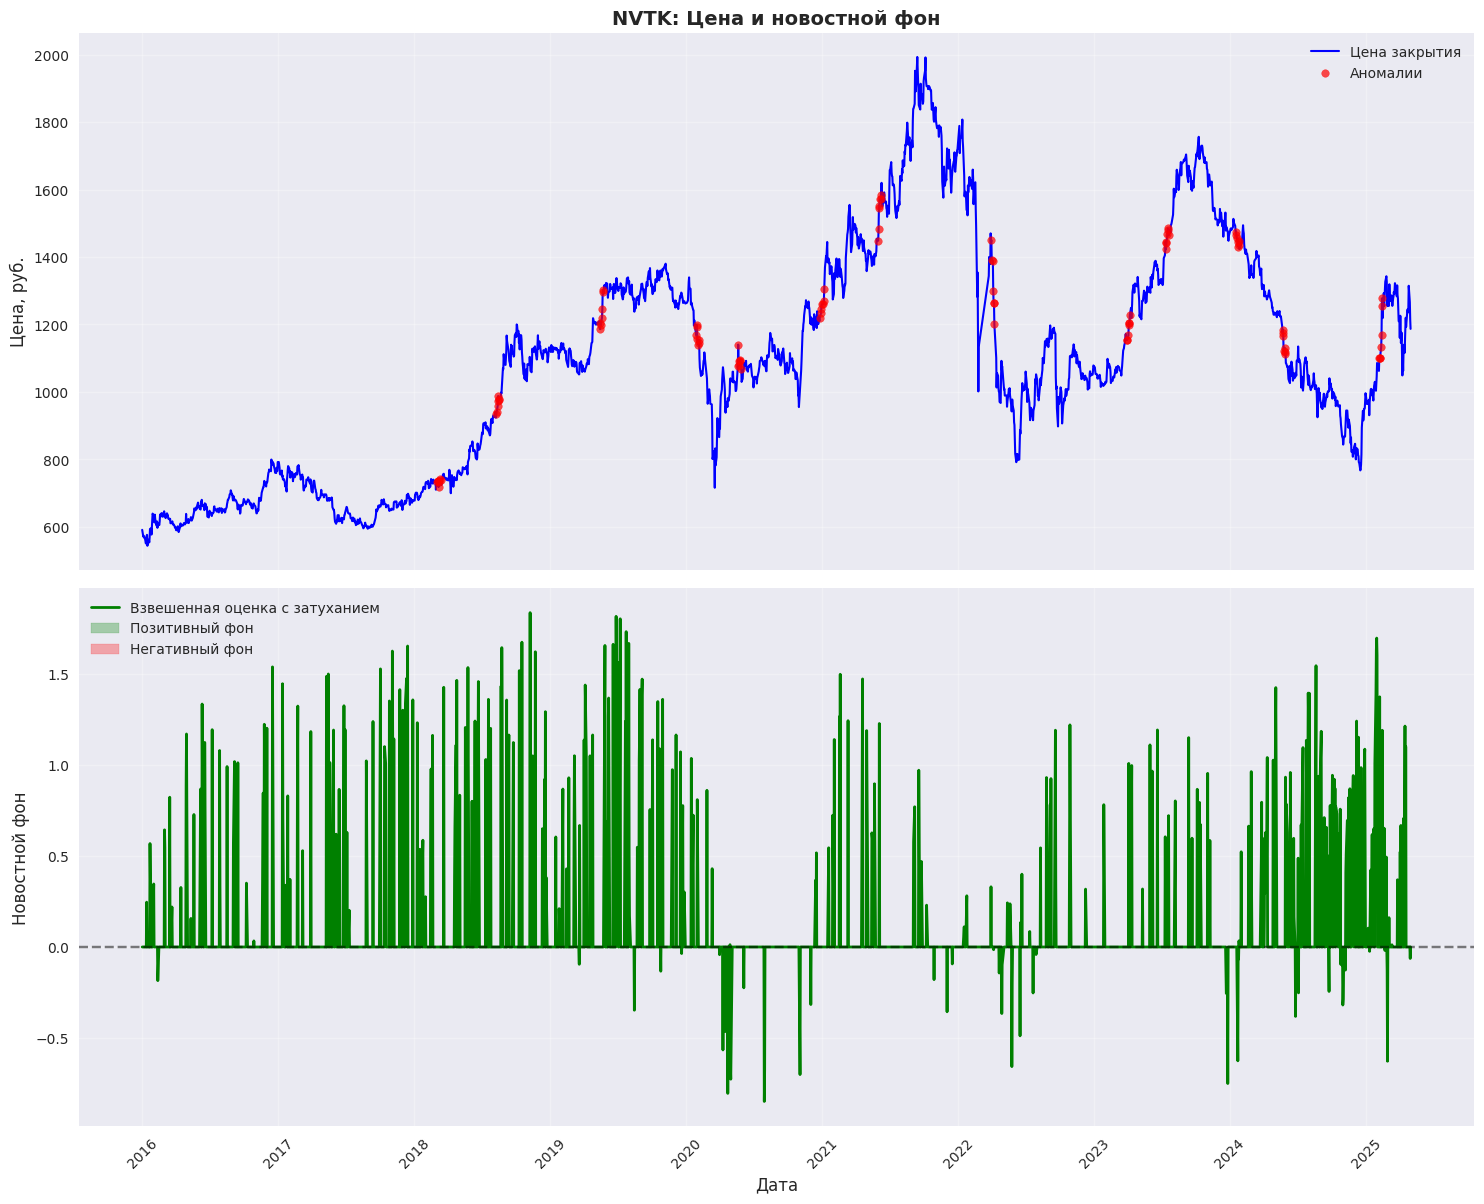


График для PIKK:


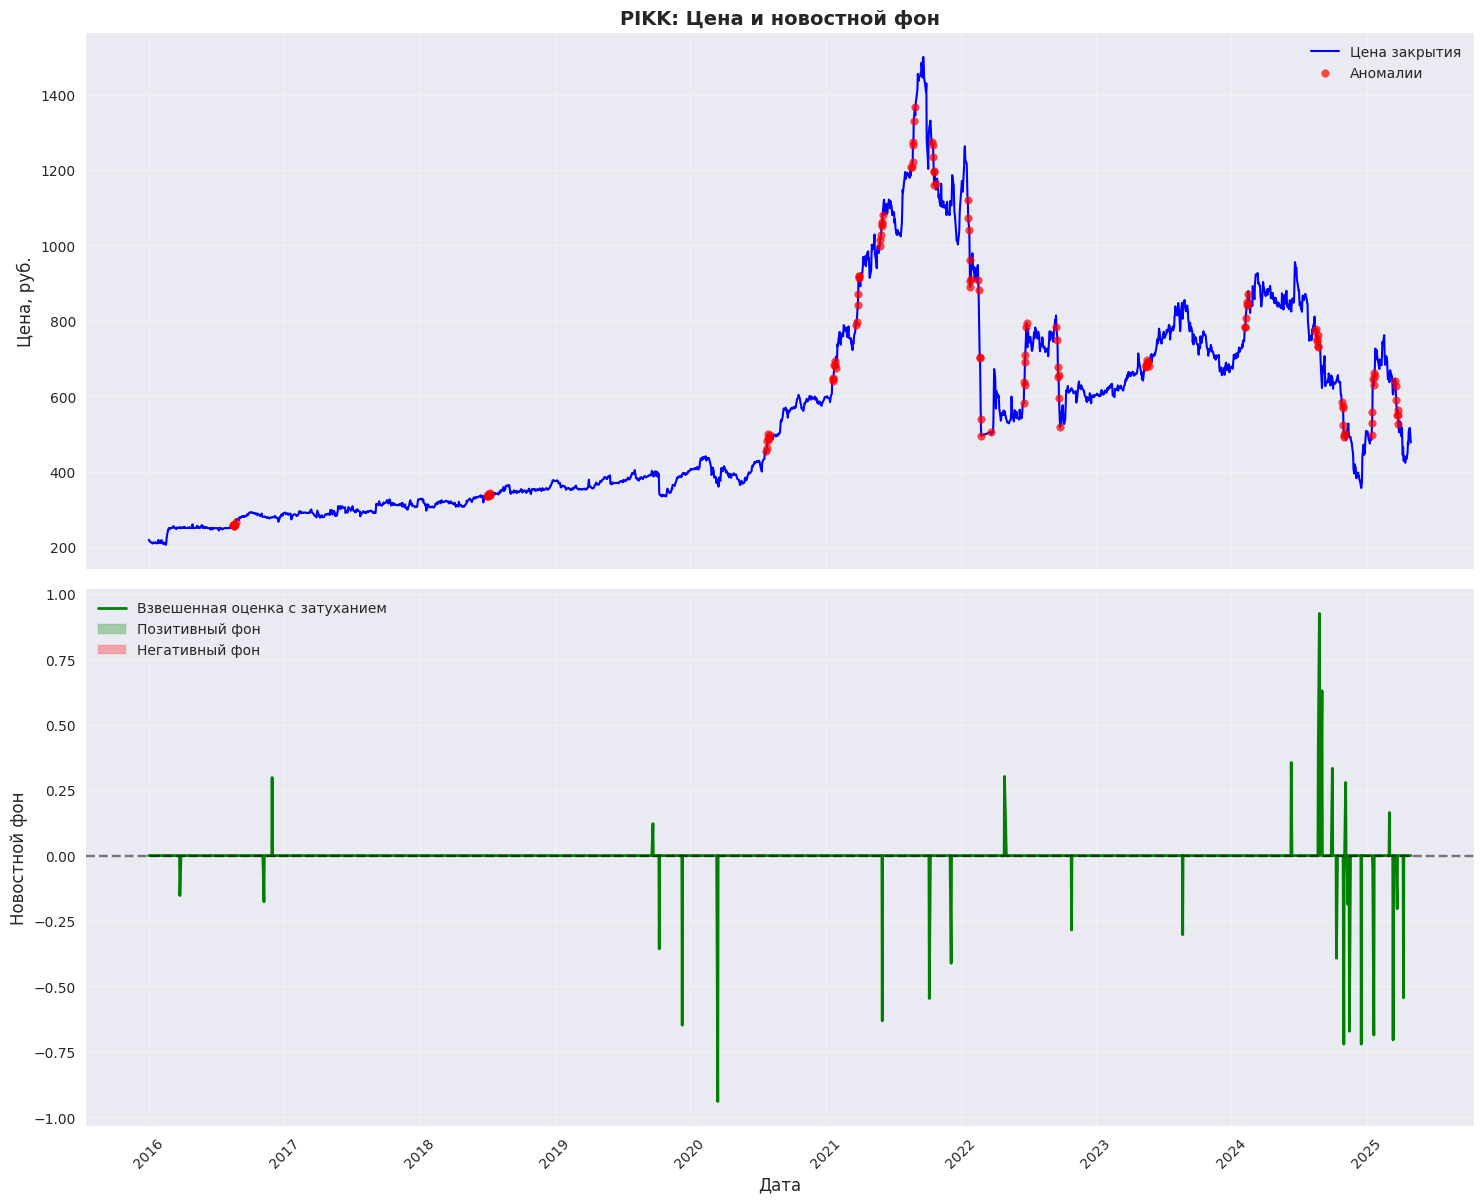


График для SBER:


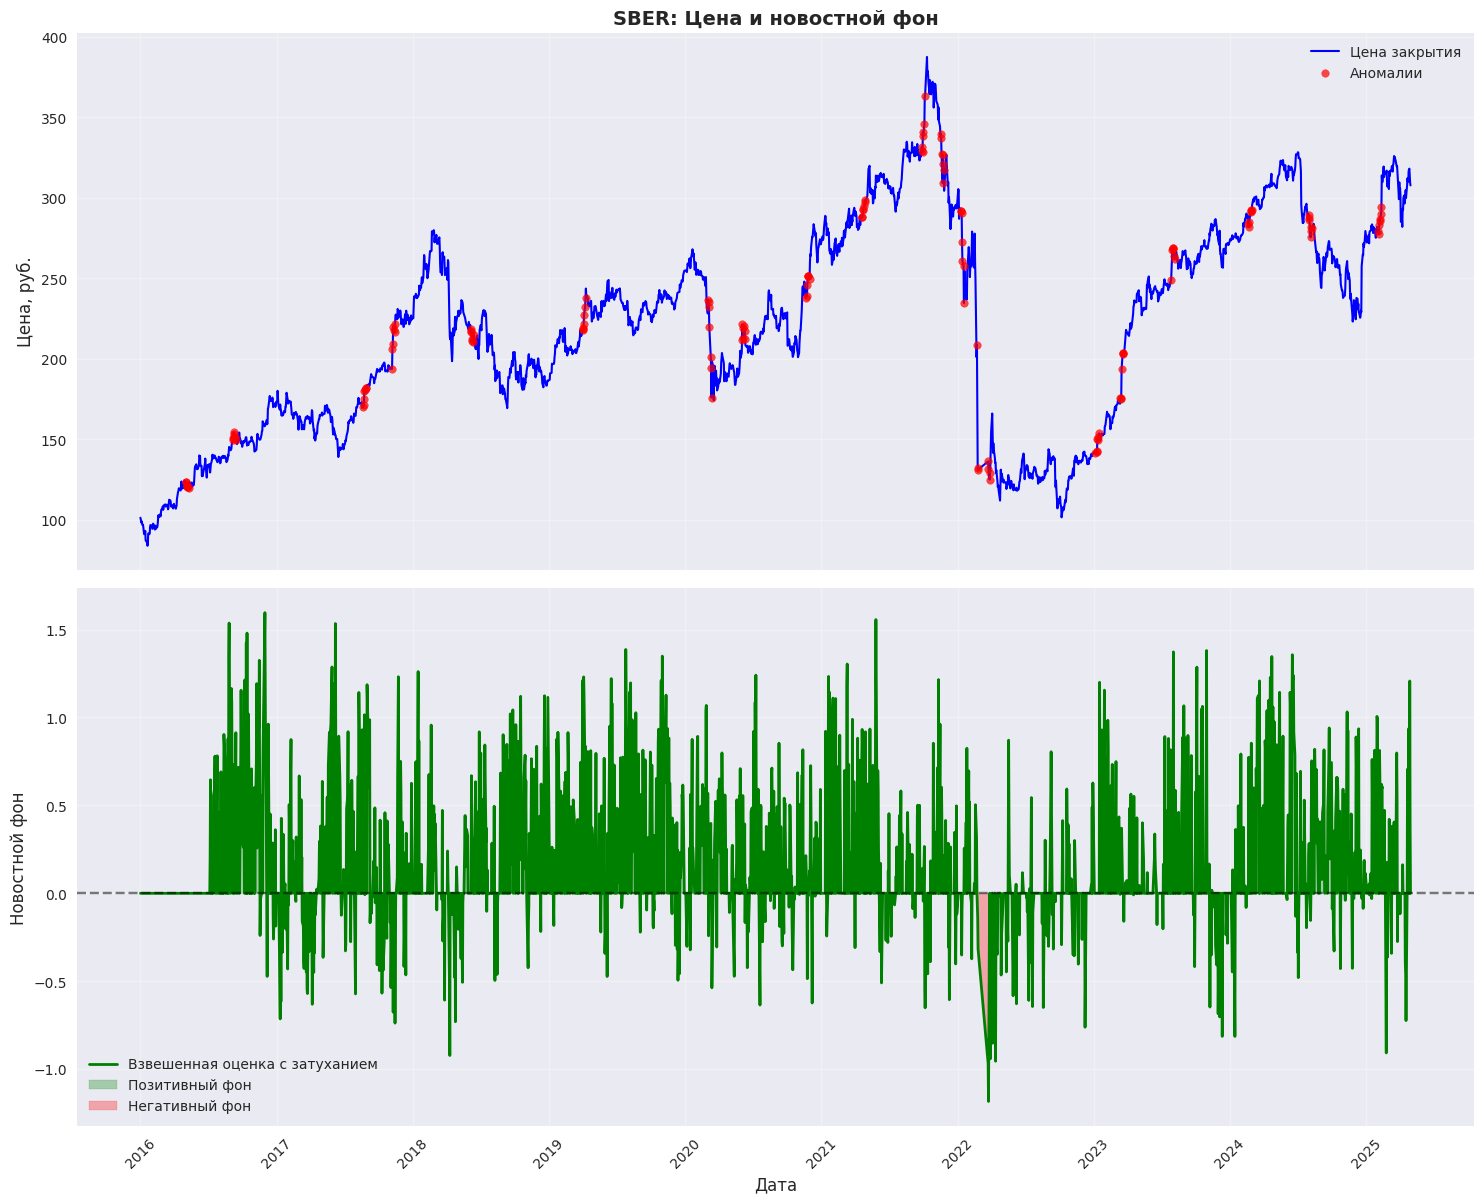


График для VKCO:


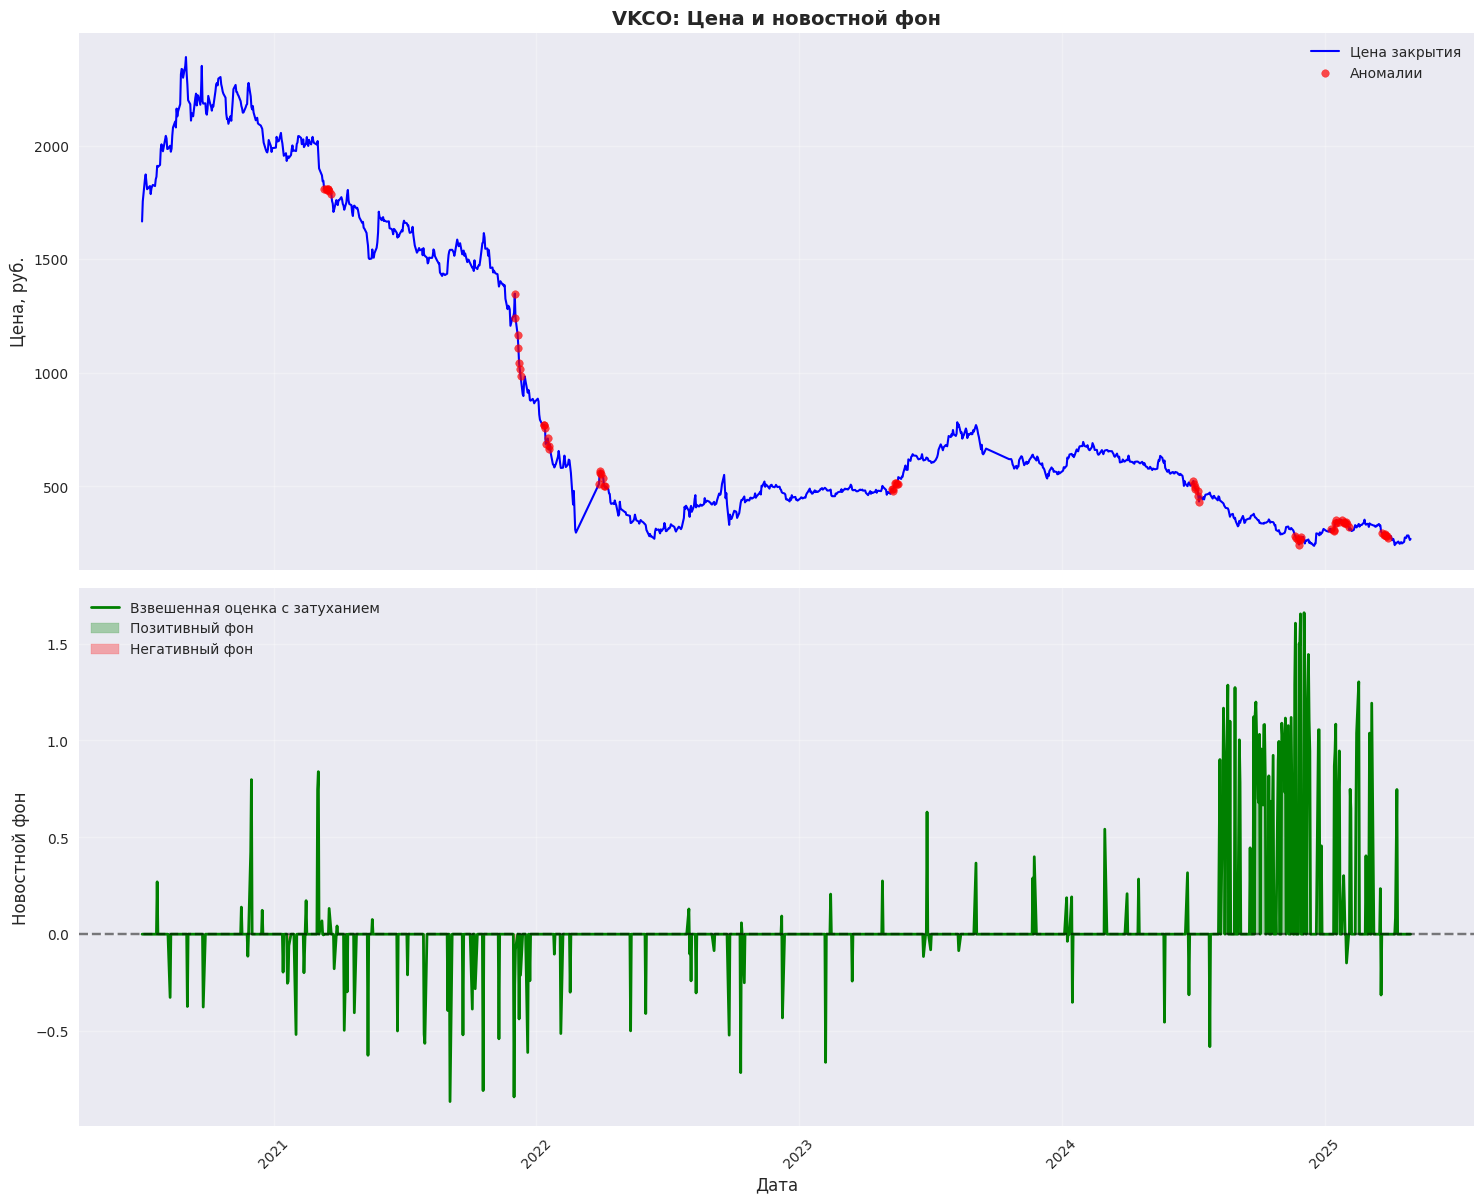


График для VTBR:


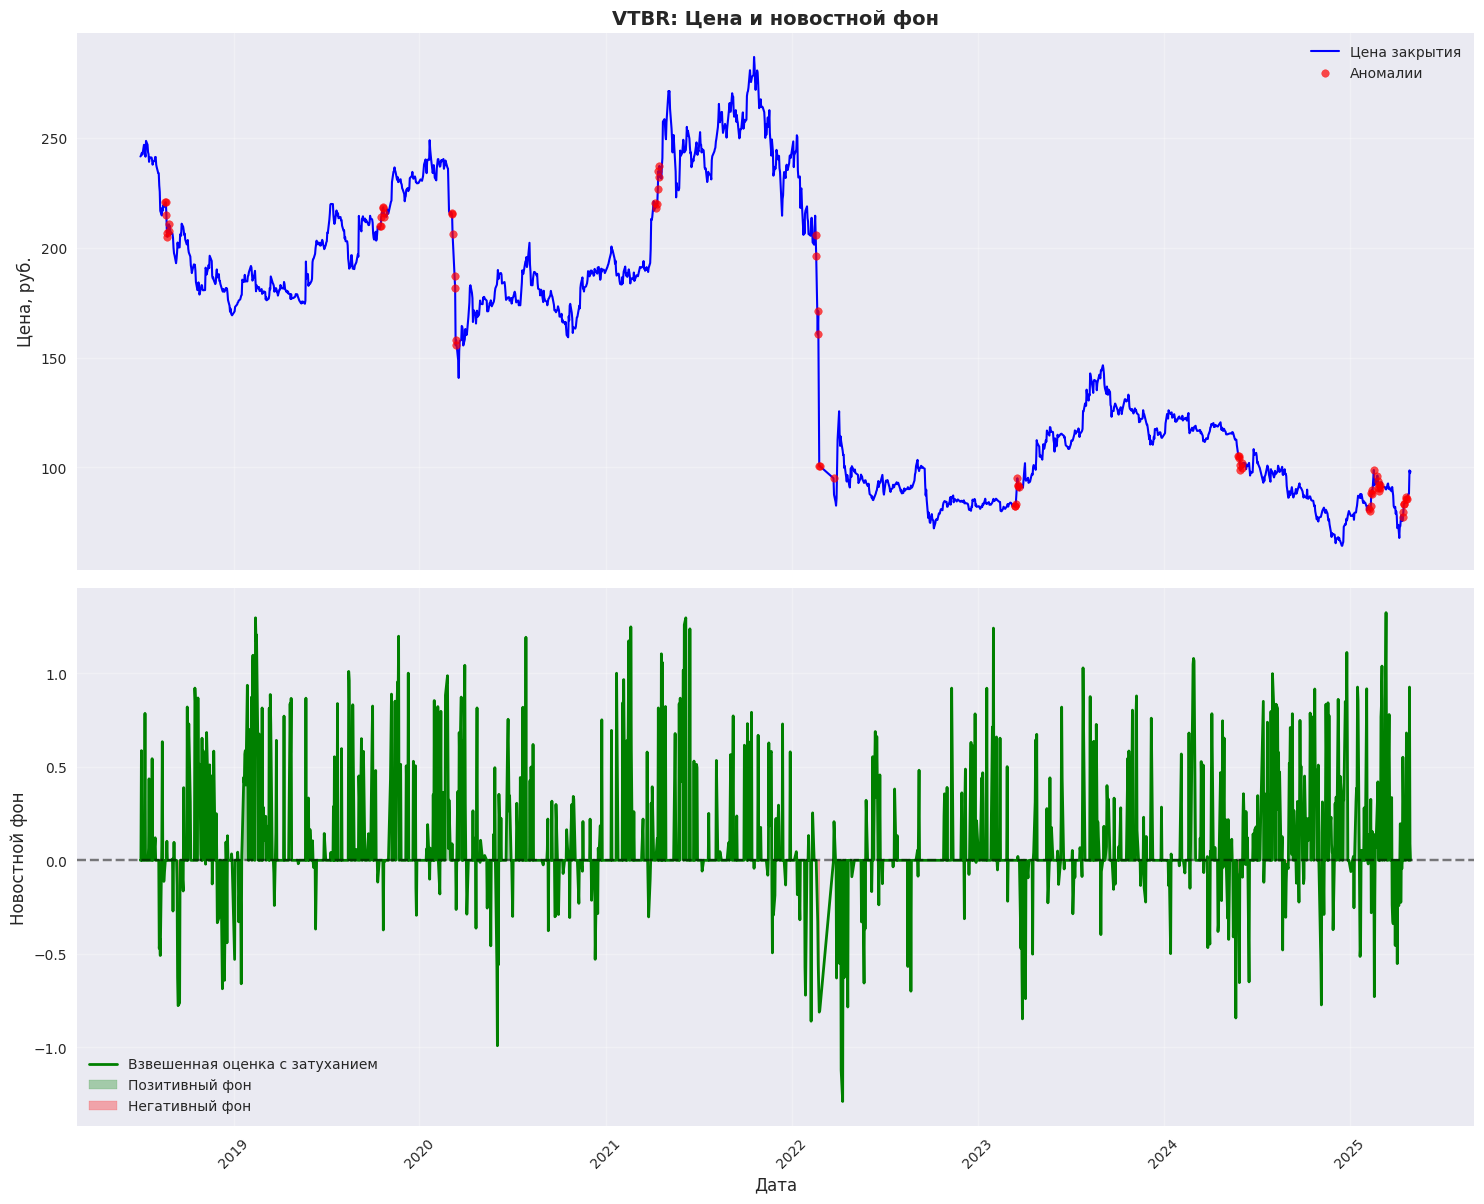


График для X5:


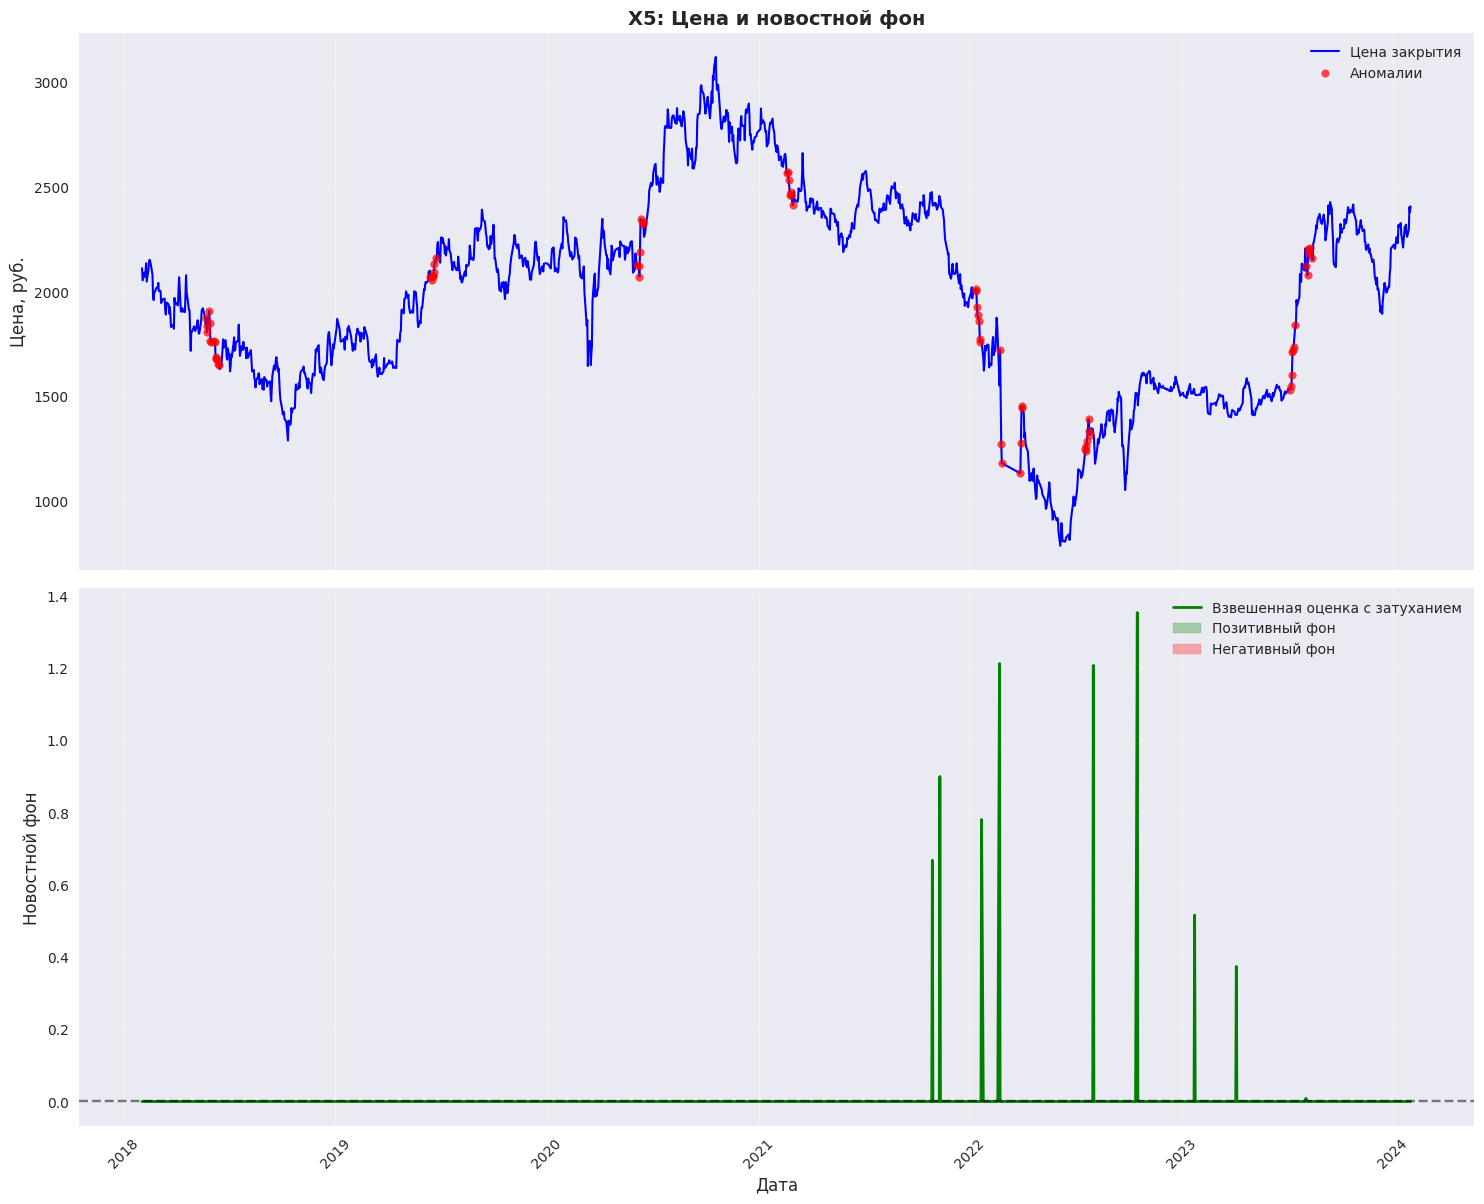


График для YDEX:


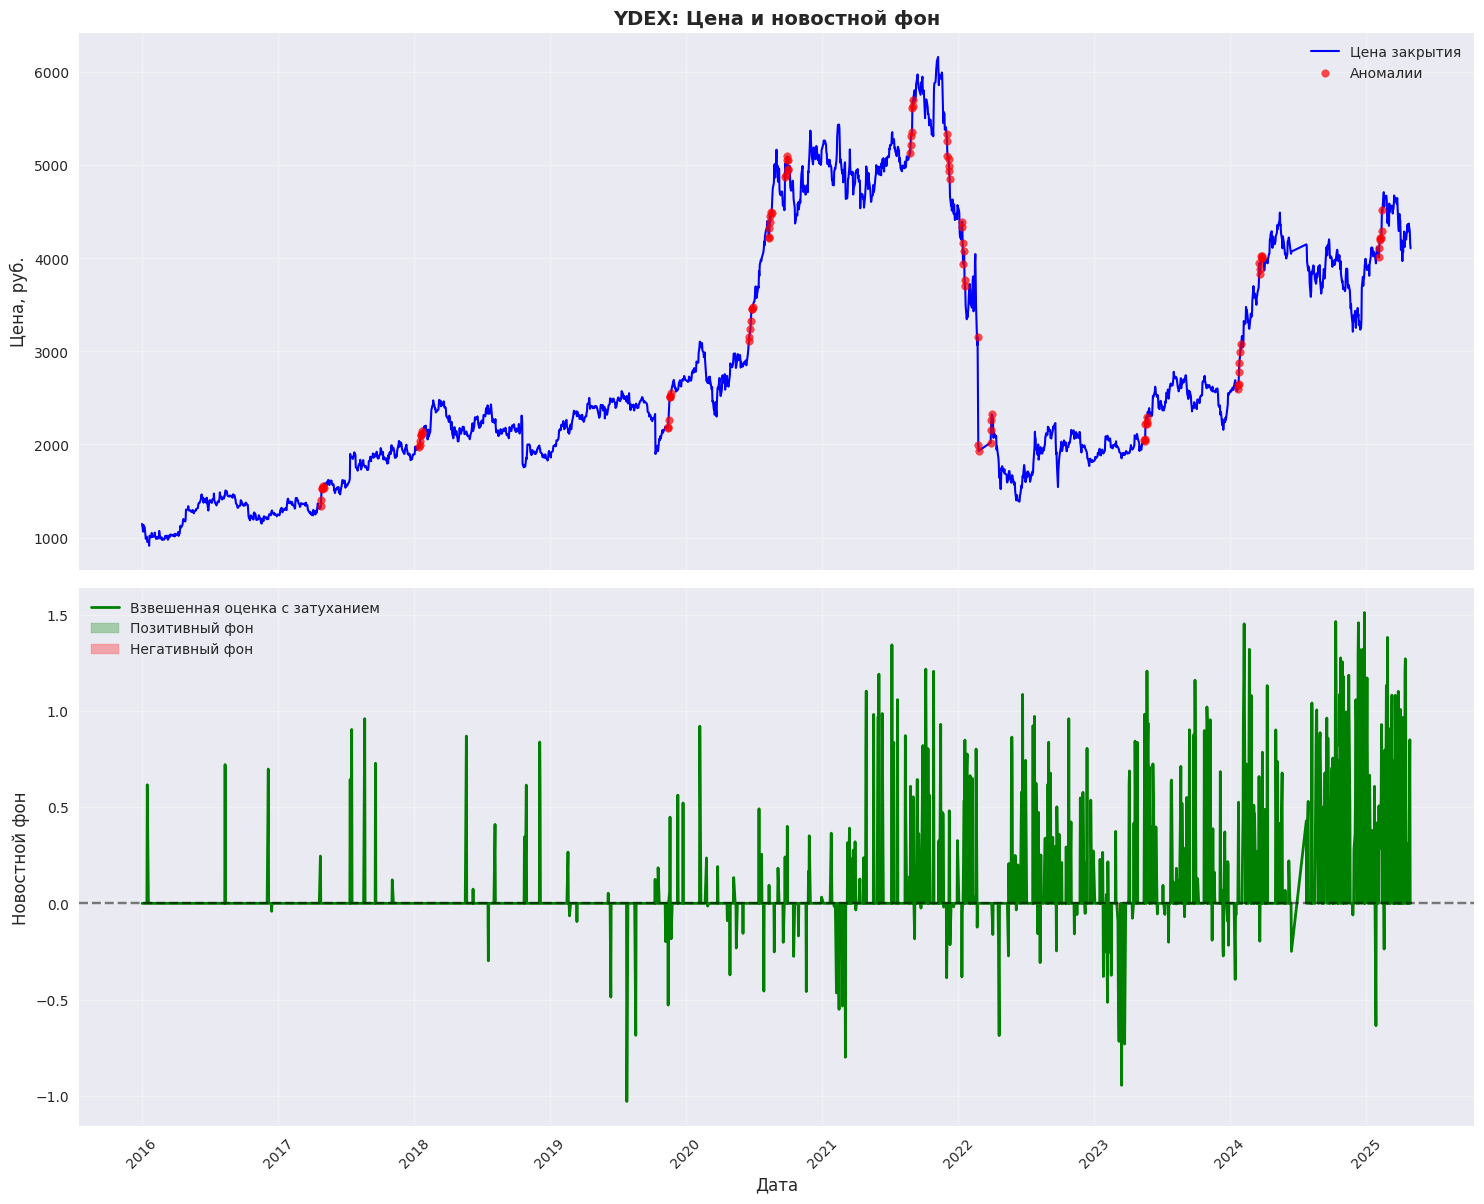

In [8]:
def plot_price_vs_news_sentiment(ticker_data, ticker_name):
    """Создает график цены и новостного фона"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    # График цены
    ax1.plot(ticker_data['timestamp'], ticker_data['close'], 
             color='blue', linewidth=1.5, label='Цена закрытия')
    
    # Выделяем аномалии
    anomaly_data = ticker_data[ticker_data['anomaly'] == 1.0]
    if len(anomaly_data) > 0:
        ax1.scatter(anomaly_data['timestamp'], anomaly_data['close'], 
                   color='red', s=30, alpha=0.7, label='Аномалии', zorder=5)
    
    ax1.set_ylabel('Цена, руб.', fontsize=12)
    ax1.set_title(f'{ticker_name}: Цена и новостной фон', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График новостного фона
    ax2.plot(ticker_data['timestamp'], ticker_data['weighted_score_with_decay'], 
             color='green', linewidth=2, label='Взвешенная оценка с затуханием')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Заливка положительных и отрицательных значений
    ax2.fill_between(ticker_data['timestamp'], ticker_data['weighted_score_with_decay'], 0,
                     where=(ticker_data['weighted_score_with_decay'] >= 0),
                     color='green', alpha=0.3, label='Позитивный фон')
    ax2.fill_between(ticker_data['timestamp'], ticker_data['weighted_score_with_decay'], 0,
                     where=(ticker_data['weighted_score_with_decay'] < 0),
                     color='red', alpha=0.3, label='Негативный фон')
    
    ax2.set_xlabel('Дата', fontsize=12)
    ax2.set_ylabel('Новостной фон', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

# Создаем графики для каждого тикера
for ticker, data in integrated_data.items():
    print(f"\nГрафик для {ticker}:")
    plot_price_vs_news_sentiment(data, ticker)

## Анализ корреляций


In [9]:
def calculate_correlations(ticker_data):
    """Вычисляет корреляции между новостным фоном и доходностями"""
    # Убираем первую строку где доходность NaN
    data_clean = ticker_data.dropna(subset=['return'])
    
    if len(data_clean) == 0:
        return {}
    
    correlations = {}
    
    # Корреляция с текущими доходностями
    correlations['current_return'] = data_clean['weighted_score_with_decay'].corr(data_clean['return'])
    
    # Корреляция с будущими доходностями (лаг 1 день)
    if len(data_clean) > 1:
        future_returns = data_clean['return'].shift(-1)
        correlations['future_return_1d'] = data_clean['weighted_score_with_decay'].corr(future_returns)
    
    # Корреляция с будущими доходностями (лаг 3 дня)
    if len(data_clean) > 3:
        future_returns_3d = data_clean['return'].shift(-3)
        correlations['future_return_3d'] = data_clean['weighted_score_with_decay'].corr(future_returns_3d)
    
    # Корреляция с будущими доходностями (лаг 7 дней)
    if len(data_clean) > 7:
        future_returns_7d = data_clean['return'].shift(-7)
        correlations['future_return_7d'] = data_clean['weighted_score_with_decay'].corr(future_returns_7d)
    
    return correlations

# Вычисляем корреляции для всех тикеров
correlation_summary = []

for ticker, data in integrated_data.items():
    correlations = calculate_correlations(data)
    
    if correlations:
        row = {'ticker': ticker}
        row.update(correlations)
        correlation_summary.append(row)
        
        print(f"\nКорреляции для {ticker}:")
        for key, value in correlations.items():
            if not pd.isna(value):
                print(f"  {key}: {value:.4f}")

# Создаем сводную таблицу корреляций
correlation_df = pd.DataFrame(correlation_summary)
print("\n" + "="*60)
print("СВОДНАЯ ТАБЛИЦА КОРРЕЛЯЦИЙ")
print("="*60)
print(correlation_df.round(4))



Корреляции для AFLT:
  current_return: 0.0242
  future_return_1d: -0.0226
  future_return_3d: 0.0161
  future_return_7d: -0.0066

Корреляции для LKOH:
  current_return: 0.0622
  future_return_1d: -0.0035
  future_return_3d: 0.0324
  future_return_7d: -0.0176

Корреляции для MOEX:
  current_return: 0.0676
  future_return_1d: -0.0112
  future_return_3d: 0.0076
  future_return_7d: 0.0017

Корреляции для NVTK:
  current_return: 0.0075
  future_return_1d: -0.0016
  future_return_3d: 0.0107
  future_return_7d: 0.0170

Корреляции для PIKK:
  current_return: 0.0545
  future_return_1d: -0.0355
  future_return_3d: -0.0798
  future_return_7d: 0.0462

Корреляции для SBER:
  current_return: 0.0230
  future_return_1d: 0.0044
  future_return_3d: 0.0114
  future_return_7d: -0.0105

Корреляции для VKCO:
  current_return: 0.0194
  future_return_1d: -0.0055
  future_return_3d: -0.0436
  future_return_7d: 0.0083

Корреляции для VTBR:
  current_return: 0.0808
  future_return_1d: 0.0387
  future_return_3d:

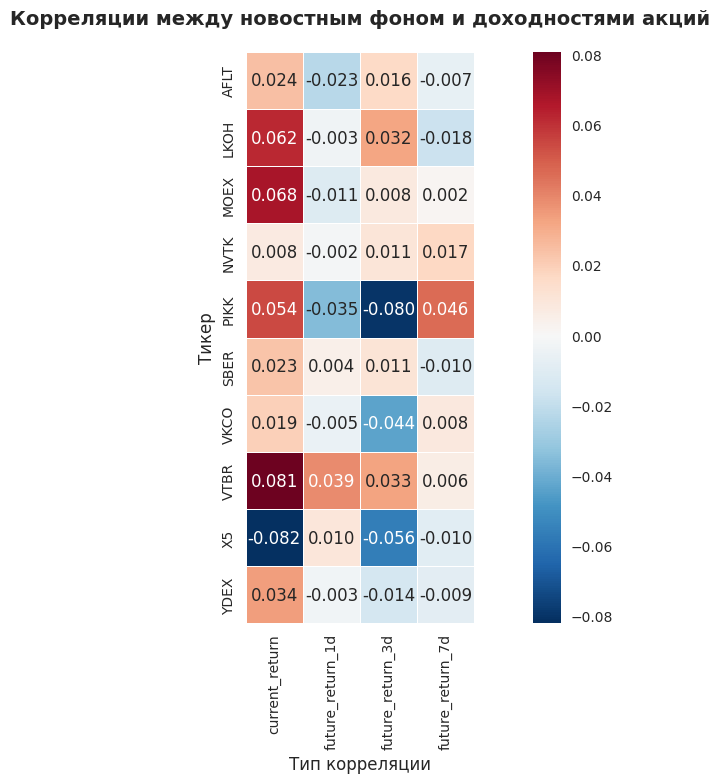


СТАТИСТИКА КОРРЕЛЯЦИЙ:
----------------------------------------

current_return:
  Среднее: 0.0291
  Медиана: 0.0291
  Стд. отклонение: 0.0459
  Мин: -0.0822
  Макс: 0.0808

future_return_1d:
  Среднее: -0.0030
  Медиана: -0.0031
  Стд. отклонение: 0.0196
  Мин: -0.0355
  Макс: 0.0387

future_return_3d:
  Среднее: -0.0084
  Медиана: 0.0092
  Стд. отклонение: 0.0389
  Мин: -0.0798
  Макс: 0.0326

future_return_7d:
  Среднее: 0.0026
  Медиана: -0.0025
  Стд. отклонение: 0.0185
  Мин: -0.0176
  Макс: 0.0462


In [10]:
# Визуализация корреляций
if len(correlation_df) > 0:
    # Подготавливаем данные для тепловой карты
    corr_matrix = correlation_df.set_index('ticker')
    
    # Создаем тепловую карту
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                fmt='.3f', square=True, linewidths=0.5)
    plt.title('Корреляции между новостным фоном и доходностями акций', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Тип корреляции', fontsize=12)
    plt.ylabel('Тикер', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Статистика по корреляциям
    print("\nСТАТИСТИКА КОРРЕЛЯЦИЙ:")
    print("-" * 40)
    for col in corr_matrix.columns:
        values = corr_matrix[col].dropna()
        if len(values) > 0:
            print(f"\n{col}:")
            print(f"  Среднее: {values.mean():.4f}")
            print(f"  Медиана: {values.median():.4f}")
            print(f"  Стд. отклонение: {values.std():.4f}")
            print(f"  Мин: {values.min():.4f}")
            print(f"  Макс: {values.max():.4f}")


## Сохранение сводных результатов


In [11]:
# Сохраняем сводную таблицу корреляций
correlation_df.to_csv(f"{OUTPUT_PATH}correlation_summary.csv", index=False)
print(f"Сводная таблица корреляций сохранена в {OUTPUT_PATH}correlation_summary.csv")

# Создаем сводку по всем обработанным файлам
summary_info = []
for ticker in tickers:
    if ticker in integrated_data:
        data = integrated_data[ticker]
        summary_info.append({
            'ticker': ticker,
            'total_records': len(data),
            'date_start': data['timestamp'].min(),
            'date_end': data['timestamp'].max(),
            'anomalies_count': data['anomaly'].sum(),
            'news_days': (data['kernai_daily_avg'] != 0).sum(),
            'avg_news_sentiment': data['weighted_score_with_decay'].mean()
        })

summary_df = pd.DataFrame(summary_info)
summary_df.to_csv(f"{OUTPUT_PATH}processing_summary.csv", index=False)

print(f"\nСводка по обработке сохранена в {OUTPUT_PATH}processing_summary.csv")
print("\nОБЗОР ОБРАБОТАННЫХ ДАННЫХ:")
print(summary_df)


Сводная таблица корреляций сохранена в ../data/series_with_news/correlation_summary.csv

Сводка по обработке сохранена в ../data/series_with_news/processing_summary.csv

ОБЗОР ОБРАБОТАННЫХ ДАННЫХ:
  ticker  total_records                date_start                  date_end  \
0   AFLT           2375 2016-01-01 00:00:00+00:00 2025-04-30 00:00:00+00:00   
1   LKOH           2375 2016-01-01 00:00:00+00:00 2025-04-30 00:00:00+00:00   
2   MOEX           2375 2016-01-01 00:00:00+00:00 2025-04-30 00:00:00+00:00   
3   NVTK           2373 2016-01-01 00:00:00+00:00 2025-04-30 00:00:00+00:00   
4   PIKK           2375 2016-01-01 00:00:00+00:00 2025-04-30 00:00:00+00:00   
5   SBER           2375 2016-01-01 00:00:00+00:00 2025-04-30 00:00:00+00:00   
6   VKCO           1197 2020-07-02 00:00:00+00:00 2025-04-30 00:00:00+00:00   
7   VTBR           1722 2018-07-02 00:00:00+00:00 2025-04-30 00:00:00+00:00   
8     X5           1499 2018-02-01 00:00:00+00:00 2024-02-01 00:00:00+00:00   
9   YDEX     

## Выводы

В данном ноутбуке была выполнена интеграция оценок новостей в временные ряды с аномалиями:

1. **Добавлены 5 новых колонок:**
   - `kernai_daily_avg` - средняя оценка за день от KerAI
   - `gigachat_daily_avg` - средняя оценка за день от Гигачат 
   - `deepseek_daily_avg` - средняя оценка за день от DeepSeek
   - `daily_headlines` - текст заголовков за день
   - `weighted_score_with_decay` - взвешенная оценка с затухающим сигналом

2. **Реализован затухающий сигнал:**
   - Влияние новостей уменьшается в 2 раза каждый день
   - За 3 дня влияние практически сводится к нулю

3. **Выполнена визуализация** цен и новостного фона для всех тикеров

4. **Рассчитаны корреляции** между новостным фоном и доходностями акций

5. **Результаты сохранены** в папку `data/series_with_news/`

Анализ корреляций позволяет оценить влияние новостного фона на динамику цен акций и выявить тикеры, наиболее чувствительные к новостным событиям.
